# <center>**IROS**<center>

**Libraries**

In [1]:
import numpy as np
import dummymoon as dm
#from scipy.signal import correlate

np.set_printoptions(precision=2, suppress=False)

In [2]:
import importlib
importlib.reload(dm)

<module 'dummymoon' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_Reconstruction_RealMasks/dummymoon/__init__.py'>

In [2]:
fits_path = "../Images_fits/wfm_mask.fits"

## **Basic IROS**

In [3]:
wfm = dm.import_mask(fits_path, False, False)

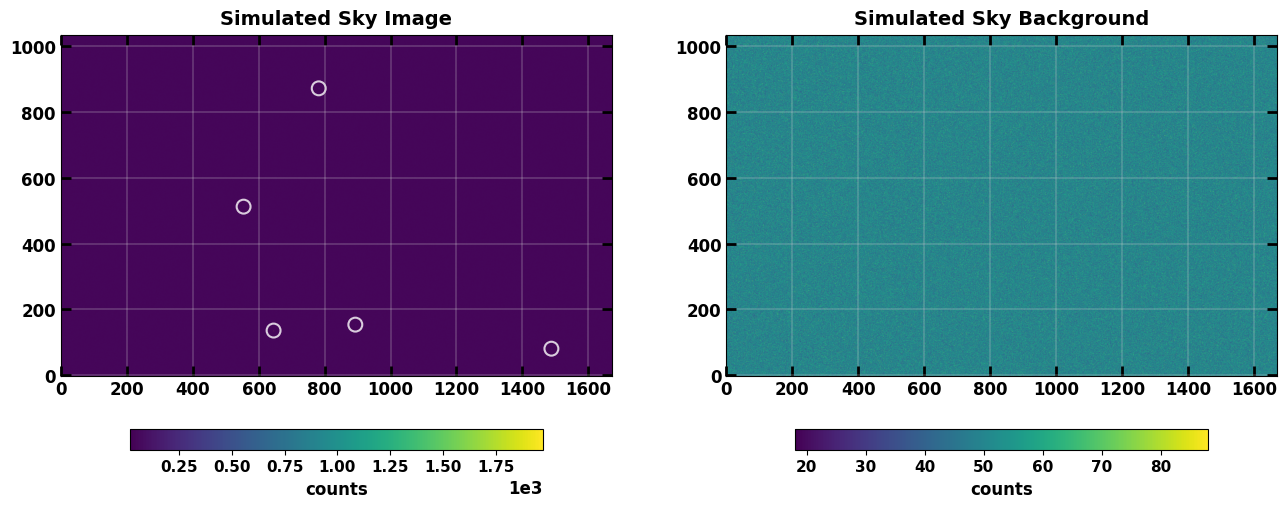

In [4]:
n_sources = 5
sources_flux = np.random.randint(int(5e2), int(2e3), size=n_sources)
sources_pos = None
sky_background_rate = int(5e1)

sky_image, sky_background, sources_pos = dm.sky_image_simulation(wfm.sky_shape, sources_flux, sources_pos, sky_background_rate)

dm.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarlabel=["counts", "counts"],
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, None])

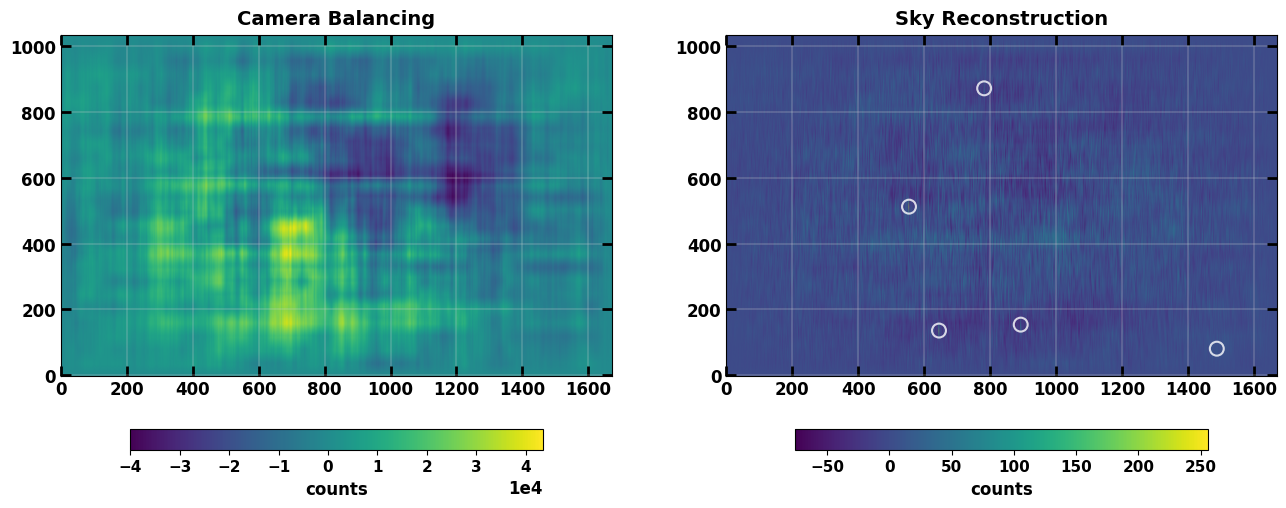

In [5]:
detector = dm.sky_encoding(wfm.mask, dm.transmitted_sky_image(sky_image, wfm), wfm.bulk)

skyrec, skyvar = dm.sky_reconstruction(wfm.mask, wfm.decoder, detector, wfm.bulk)
bal = dm.camera_balancing(wfm.decoder, wfm.bulk)*detector.sum()/wfm.bulk.sum()

dm.image_plot([bal, skyrec/wfm.specs['real_open_fraction']],
                ["Camera Balancing", "Sky Reconstruction"],
                cbarlabel=["counts", "counts"],
                #cbarlimits=[(None, None), (np.quantile(skyrec, q), np.quantile(skyrec, 1 - q))],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

show_slices = False
if show_slices:
    dm.enhance_skyrec_slices(skyrec, sources_pos)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_35860/2524455218.py:6: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],
/tmp/ipykernel_35860/2524455218.py:17: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
/tmp/ipykernel_35860/2524455218.py:17: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],


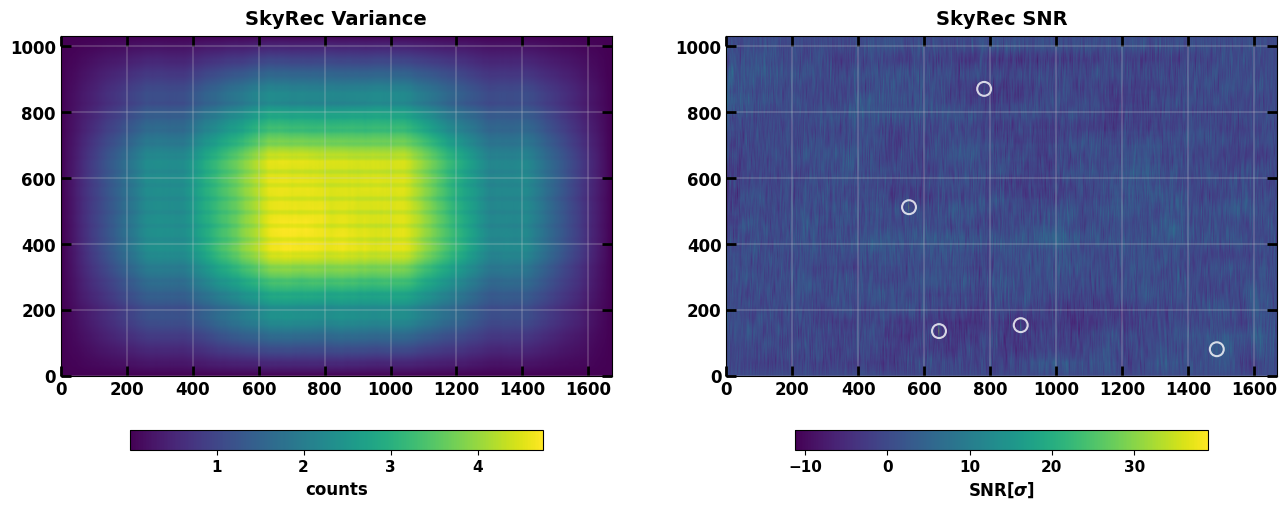

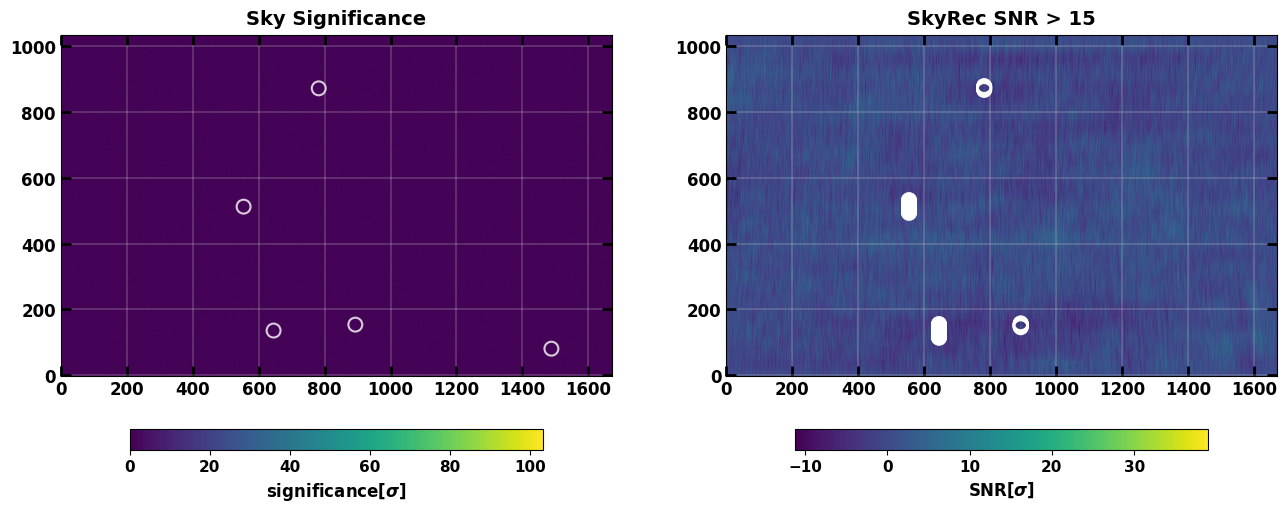

In [8]:
skysnr = dm.sky_snr(skyrec, skyvar)


dm.image_plot([skyvar, skysnr],
                ["SkyRec Variance", "SkyRec SNR"],
                cbarlabel=["counts", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

thres_snr = 15
loc = np.argwhere(skysnr > thres_snr).T

dm.image_plot([dm.sky_significance(sky_image, sky_background_rate), skysnr],
                ["Sky Significance", f"SkyRec SNR > {thres_snr}"],
                cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, np.dstack((loc[0], loc[1]))[0]])

<br>

**Let's apply IROS...**

In [11]:
perform = False

if perform:

    thres = 5

    loop = dm.IROS(
        n_iterations=30,
        skysnr=skysnr,
        skymap=skyrec,
        detector_img=detector,
        snr_threshold=thres,
        cam=wfm,
        show_snr_distr=True,
        show_peaks_num=True,
    )

    show_cropping = False
    show_results = False

    for idx, obj in enumerate(loop):
        sources, sky, snr = obj

        if show_cropping:
            k = 0
            print(f"Max SNR source pos: {sources['sources_pos'][k]}")
            dm.image_plot([dm.crop(sky, sources['sources_pos'][k], (30, 30)), dm.crop(snr, sources['sources_pos'][k], (30, 30))],
                        [f"Max SNR $S_{{{k}}}$ Reconstr.", f"Max SNR $S_{{{k}}}$ Value, iter. {idx}"],
                        cbarlabel=["counts", "SNR[$\sigma$]"],
                        cbarcmap=['viridis']*2)

        if show_results:
            dm.image_plot([skyrec, sky],
                            ["Sky Reconstruction", f"SkyRec IROS, iter. {idx}"],
                            cbarlabel=["counts", "counts"],
                            cbarcmap=['viridis']*2,
                            simulated_sources=[sources_pos]*2)

            dm.image_plot([snr, skyrec - sky],
                            [f"IROS iter. {idx} SNR", f"Residues: SkyRec - IROS{idx}"],
                            cbarlabel=["counts", "counts"],
                            cbarcmap=['viridis']*2,
                            simulated_sources=[sources_pos]*2)

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_35860/2804759072.py:29: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],


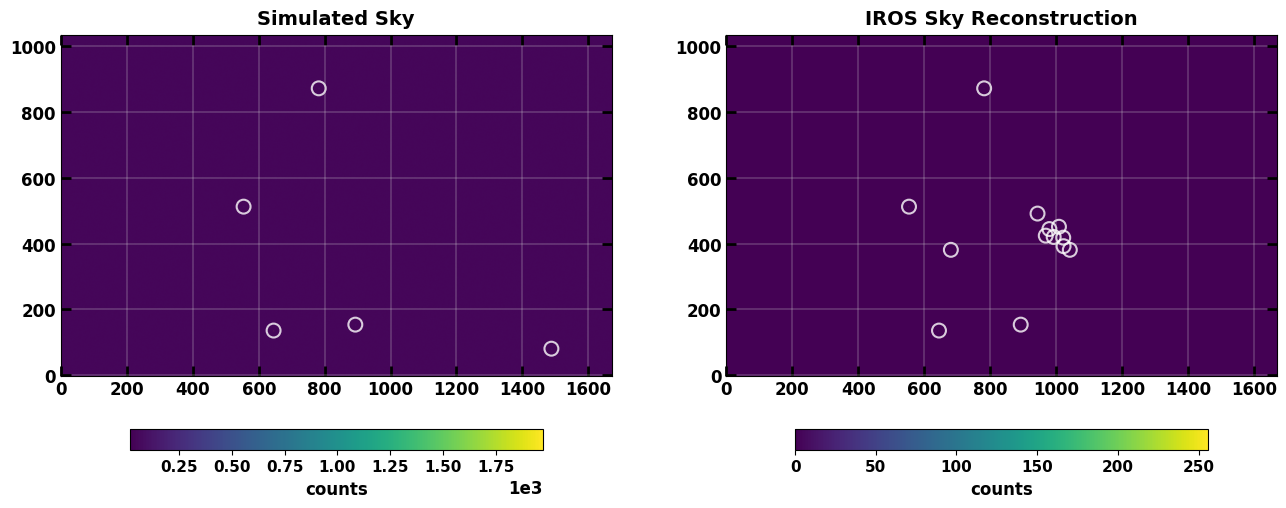

In [10]:
dm.iros_skyrec(sky_image, sources_pos, sources, wfm)

<br>

<br>

<br>

In [11]:
def shadowgram(pos: tuple[int, int],
                counts: int | float,
                cam: object,
                ) -> np.array:
    
    s = np.zeros(cam.sky_shape)
    s[*pos] = counts
    det = dm.sky_encoding(cam.mask, s, cam.bulk)
    assert det.shape == cam.detector_shape

    return det

def argmax(composed: np.array) -> tuple[int, int]:
    row, col = np.unravel_index(np.argmax(composed), composed.shape)
    return int(row), int(col)

def record_source(sources_log: dict,
                pos: np.array,
                counts: int | float,
                snr_value: int | float,
                ) -> dict:
    sources_log['sources_pos'].append(pos)
    sources_log['sources_counts'].append(counts)
    sources_log['sources_snrs'].append(snr_value)
    return sources_log

def compare(loc):
    print(f"Recovered position: {loc}\n"
          f"Sources pos: {sources_pos}\n"
          f"Pos in simulated positions: {loc in sources_pos}")

In [12]:
sources_dataset = {'sources_pos': [],
                    'sources_counts': [],
                    'sources_snrs': []}

Recovered position: (251, 870)
Sources pos: [(714, 87), (798, 1461), (133, 1277), (1020, 781), (251, 870)]
Pos in simulated positions: True


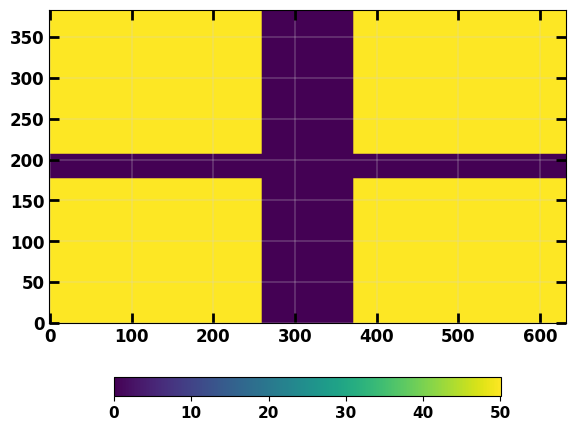

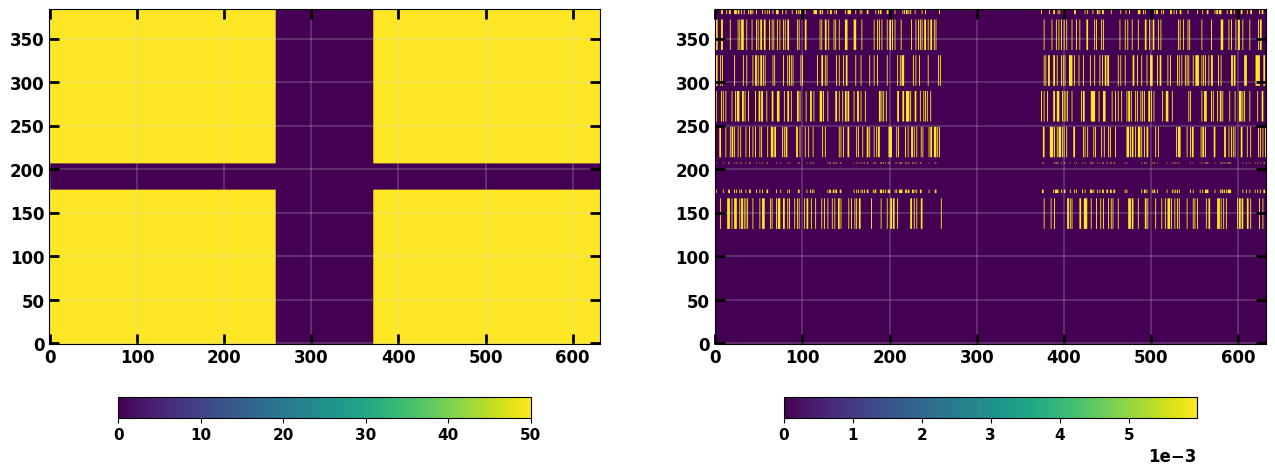

In [13]:
loc = argmax(skysnr)
compare(loc)

if loc not in sources_pos:
    record_source(sources_dataset, loc, skyrec[*loc], skysnr[*loc])

dm.image_plot([detector], [""])

s = shadowgram(loc, skyrec[*loc], wfm)
det = detector - s

dm.image_plot([det, s], [""]*2)

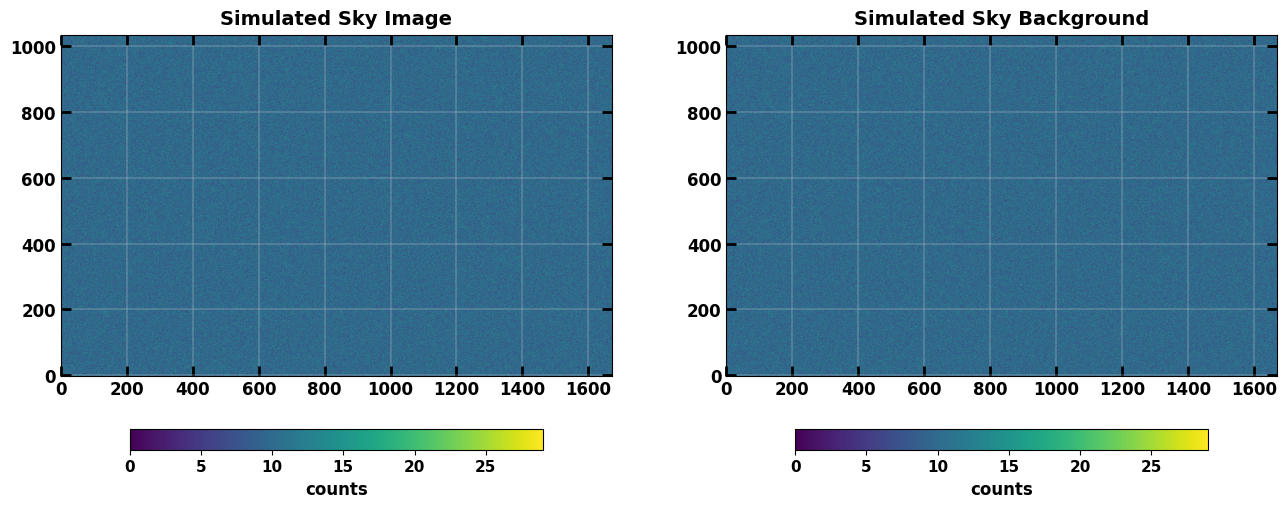

In [4]:
n_sources = 0
sources_flux = np.random.randint(int(5e2), int(2e3), size=n_sources)
sources_pos = None
sky_background_rate = 10

sky_image, sky_background, sources_pos = dm.sky_image_simulation(wfm.sky_shape, sources_flux, sources_pos, sky_background_rate)

dm.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarlabel=["counts", "counts"],
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, None])

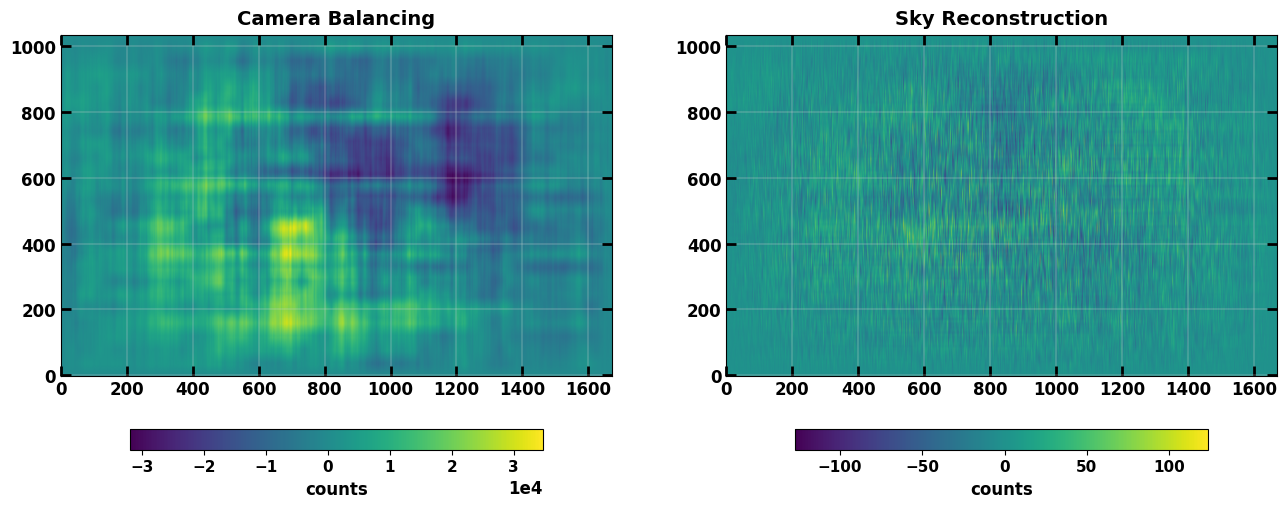

In [5]:
detector = dm.sky_encoding(wfm.mask, sky_image, wfm.bulk)

skyrec, skyvar = dm.sky_reconstruction(wfm.mask, wfm.decoder, detector, wfm.bulk)
bal = dm.camera_balancing(wfm.decoder, wfm.bulk)*detector.sum()/wfm.bulk.sum()

scaling = 1.0/0.2504

dm.image_plot([bal, skyrec*scaling],
                ["Camera Balancing", "Sky Reconstruction"],
                cbarlabel=["counts", "counts"],
                #cbarlimits=[(None, None), (np.quantile(skyrec, q), np.quantile(skyrec, 1 - q))],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

show_slices = False
if show_slices:
    dm.enhance_skyrec_slices(skyrec, sources_pos)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_61023/3230039910.py:6: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],
/tmp/ipykernel_61023/3230039910.py:18: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
/tmp/ipykernel_61023/3230039910.py:18: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],


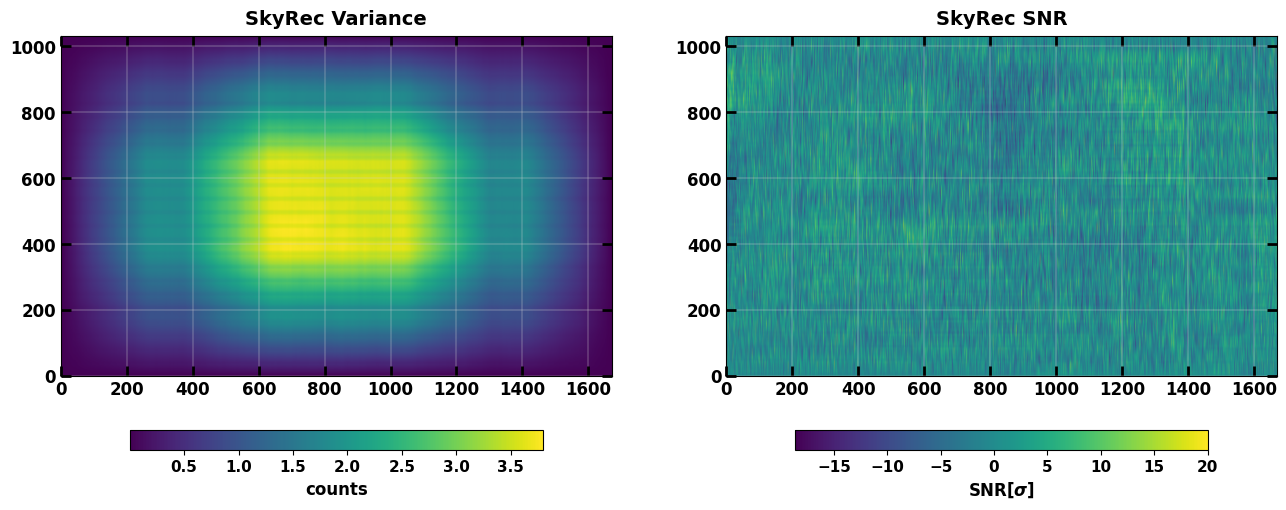

In [6]:
skysnr = dm.sky_snr(skyrec, skyvar)


dm.image_plot([skyvar, skysnr],
                ["SkyRec Variance", "SkyRec SNR"],
                cbarlabel=["counts", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

if False:
    thres_snr = 20
    loc = np.argwhere(skysnr > thres_snr).T

    dm.image_plot([dm.sky_significance(sky_image, sky_background_rate), skysnr],
                    ["Sky Significance", f"SkyRec SNR > {thres_snr}"],
                    cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
                    cbarlimits=[(None, None), (None, None)],
                    cbarscinot=[True]*2,
                    cbarcmap=["viridis"]*2,
                    simulated_sources=[sources_pos, np.dstack((loc[0], loc[1]))[0]])

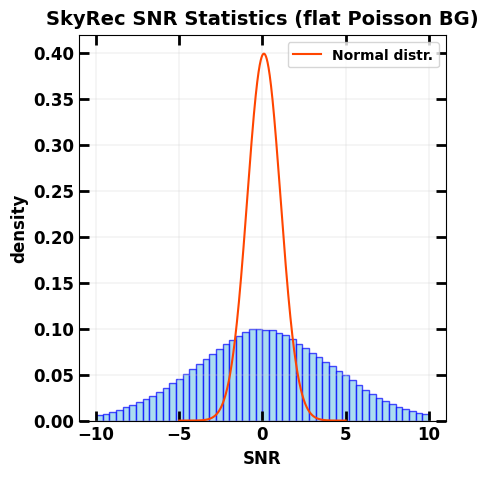

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
fig.tight_layout()
ax.hist(skysnr.reshape(-1), bins=50, range=(-10, 10), density= True,
        color='SkyBlue', edgecolor='b', alpha=0.7)
ax.plot(x := np.linspace(-5, 5, 1000), np.exp(-0.5*(np.square(x - skysnr.mean())))/np.sqrt(2*np.pi),
        color="OrangeRed", label="Normal distr.")
ax.set_xlabel("SNR", fontsize=12, fontweight='bold')
ax.set_ylabel("density", fontsize=12, fontweight='bold')
ax.set_title(f"SkyRec SNR Statistics (flat Poisson BG)",
                fontsize=14, pad=8, fontweight='bold')
ax.grid(visible=True, color="lightgray", linestyle="-", linewidth=0.3)
ax.legend(loc='best')
ax.tick_params(which='both', direction='in', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.show()